### Найти процент заполненности решётки p*, при котором отношение числа кооператоров к числу "невыключенных" игроков максимально для b = 1.81

In [1]:
from Assemblies.game import GameField
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
eps = 0.01
bs = 9/5+eps
#размер поля 300x300 (в работе также рассматриваются поля 200x200 и 100x100)
L = 300
cp = 50
#процент выключенных узлов offp_close соответствует (100 - offp_close) проценту заполненности решётки
offp_close = np.linspace(23, 15, num=17, dtype=float)

seeds = np.zeros(100,dtype=int)
for i in range(100):
    seeds[i] = i + 1

    
#3000 шагов отжига и 500 щагов эволюции
burnin1 = 3000
evol1 = 500

n = len(seeds)
m = len(offp_close)

In [3]:
#плотность для конкретного b
def c_density(size, coop_percentage, off_percentage, seed, burnin, evol, b): 
    np.random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    #здесь active означает места, занятые кооператорами или дефекторами
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    density = np.zeros(evol)
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(burnin)
    for step in range(evol):
        game.evolveQ(1)
        density[step] = np.count_nonzero(np.equal(game.field,0)) / len(active)
    return density

In [4]:
#измеряем плотность для одной реализации на протяжении evol1 шагов. 
#усредняем по шагам.

#функция возвращает массив плотности по значениям off_percentage для определённого процента кооператоров и определённого b
def total_density(size, coop_percentage, off_percentage, seed, burnin, evol, b):
    
    aver_all=np.zeros(len(off_percentage))
    for i in range(len(off_percentage)):
        den=np.zeros(evol)
        den=c_density(size, coop_percentage, off_percentage[i], seed, burnin, evol, b)
        aver_all[i]=np.mean(den)

    return aver_all 

### Вблизи p* для 300x300 

In [5]:
#среднее по шагам
den_close300 = np.zeros((len(seeds), len(offp_close)))
for i in range(len(seeds)):
    den_close300[i] = total_density(size=L, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

### Вблизи p* для 100x100

In [7]:
den_close100 = np.zeros((len(seeds), len(offp_close)))
for i in range(len(seeds)):
    den_close100[i] = total_density(size=100, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

### Вблизи p* для 200x200

In [9]:
den_close200 = np.zeros((len(seeds), len(offp_close)))
for i in range(len(seeds)):
    den_close200[i] = total_density(size=200, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

### Запись в файл

#### 300x300 

In [4]:
#переводим в список перед записью в файл
line300 = list(np.reshape(den_close300, (n * m,)))

with open('out300.txt', 'w', encoding='utf8') as f300:
    json.dump(line300, f300)
f300.close()

#### 100x100 

In [69]:
line100 = list(np.reshape(den_close100, (n * m,)))

with open('out100.txt', 'w', encoding='utf8') as f100:
    json.dump(line100, f100)
f100.close()

#### 200x200 

In [70]:
line200 = list(np.reshape(den_close200, (n * m,)))

with open('out200.txt', 'w', encoding='utf8') as f200:
    json.dump(line200, f200)
f200.close()

### Чтение из файла

In [3]:
with open('out300.txt', 'r', encoding='utf8') as f300:
    #достаём массив обратно
    copy300 = np.reshape(np.array(json.load(f300)), (n, m))

with open('out100.txt', 'r', encoding='utf8') as f100:
    copy100 = np.reshape(np.array(json.load(f100)), (n, m))
    
with open('out200.txt', 'r', encoding='utf8') as f200:
    copy200 = np.reshape(np.array(json.load(f200)), (n, m))

### Среднее по реализации

In [4]:
aver_close300 = np.mean(copy300, axis=0) 
aver_close100 = np.mean(copy100, axis=0)
aver_close200 = np.mean(copy200, axis=0)

### Стандартная ошибка среднего (по реализациям)

Вычисляется как $\frac{\sqrt{\frac{1}{n}\sum\limits_{i=1}^n{(x_i - \overline{x})}^2}}{\sqrt{n}}$, где

$x_i$ - среднее значение плотности по шагам для одной реализации

$\overline{x}$ - среднее значение плотности по шагам и по реализациям

$n$ - количество реализаций

In [5]:
errs300 = np.zeros(len(aver_close300))
for i in range(len(aver_close300)):
    errs300[i] = np.sqrt(sum((aver_close300[i] - copy300[::, i]) ** 2) / n) / np.sqrt(n)
    
errs100 = np.zeros(len(aver_close100))
for i in range(len(aver_close100)):
    errs100[i] = np.sqrt(sum((aver_close100[i] - copy100[::, i]) ** 2) / n) / np.sqrt(n)
    
errs200 = np.zeros(len(aver_close200))
for i in range(len(aver_close200)):
    errs200[i] = np.sqrt(sum((aver_close200[i] - copy200[::, i]) ** 2) / n) / np.sqrt(n)        

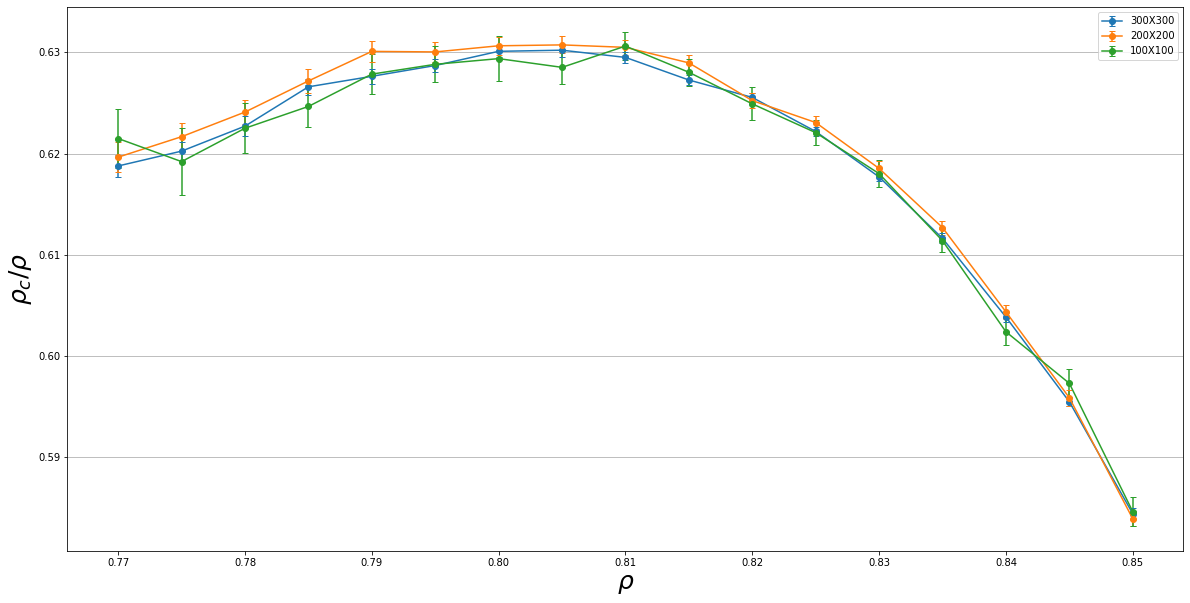

In [6]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
#scale = 10
#plt.clf()
#plt.figure(figsize = (scale, scale))

ax.errorbar(1-offp_close*0.01, aver_close300, yerr=errs300, fmt='o-', capsize=3, label='300X300')
ax.errorbar(1-offp_close*0.01, aver_close200, yerr=errs200, fmt='o-', capsize=3, label='200X200')
ax.errorbar(1-offp_close*0.01, aver_close100, yerr=errs100, fmt='o-', capsize=3, label='100X100')
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()

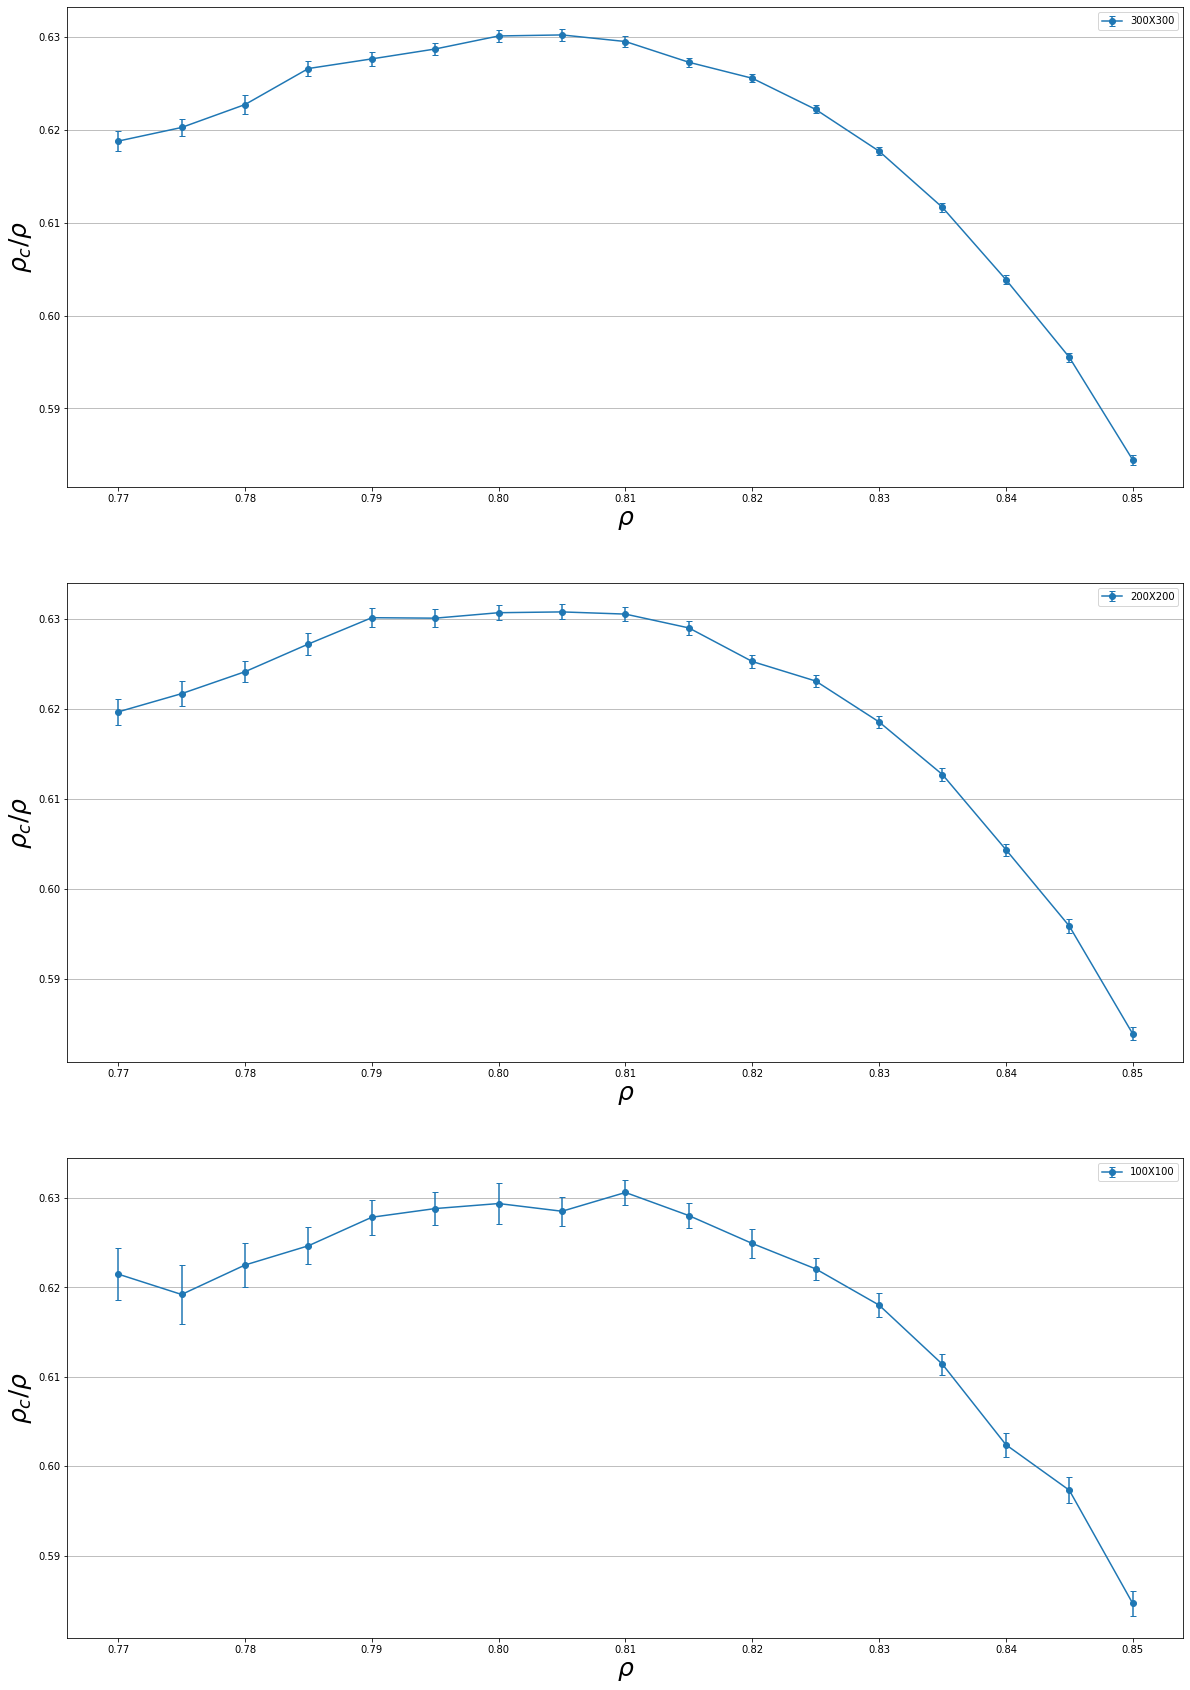

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,30))
#scale = 10
#plt.clf()
#plt.figure(figsize = (scale, scale))

ax1.errorbar(1-offp_close*0.01, aver_close300, yerr=errs300, fmt='o-', capsize=3, label='300X300')
ax2.errorbar(1-offp_close*0.01, aver_close200, yerr=errs200, fmt='o-', capsize=3, label='200X200')
ax3.errorbar(1-offp_close*0.01, aver_close100, yerr=errs100, fmt='o-', capsize=3, label='100X100')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
    ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
    ax.legend()
    ax.grid(b=True,axis='y')

In [13]:
maxind300=np.argmax(aver_close300)
p_star=(100-offp_close)[maxind300]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  80.5


In [9]:
maxind200=np.argmax(aver_close200)
p_star=(100-offp_close)[maxind200]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  80.5


In [10]:
maxind100=np.argmax(aver_close100)
p_star=(100-offp_close)[maxind100]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  81.0


## Persistence

In [3]:
#массив значений persistence на протяжении t-tw шагов для определённой реализации игры
def persistence(size, coop_percentage, off_percentage, seed, b, t, tw):
    np.random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    
    c=active_size
    persistence=np.zeros(t-tw)
    
    #флаги индексы элементов
    #0 - прошёл проверку на неизменность стратегий, 1 - не прошёл
    dropout_flags=np.zeros(active_size, dtype=int) 
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(tw)
    for step in range(t-tw):
        game.evolveQ(1)
        
        evolution=np.copy(game.field[active_indexes])
        
        for i in range(len(evolution)):
            if (dropout_flags[i]!=1) and (evolution[i]!=active[i]):
                c-=1
                dropout_flags[i]=1
        
        persistence[step]=c/active_size
    return persistence

In [14]:
points_close=np.linspace(60, p_star, num=42, dtype=float)
n = len(seeds)
m = len(points_close)

In [5]:
t1=3000
tw1=0

pers_close=np.zeros((n, m))
for j in range(n):
    for i in range(m):
        pers_close[j][i]=persistence(size=200,coop_percentage=cp,off_percentage=100 - points_close[i],seed=seeds[j],b=bs,t=t1,tw=tw1)[-1]
    #print('seed =', seeds[j])

In [33]:
line_pers = list(np.reshape(pers_close, (n * m,)))

with open('pers.txt', 'w', encoding='utf8') as f:
    json.dump(line_pers, f)
f.close()

In [15]:
with open('pers.txt', 'r', encoding='utf8') as f:
    copy_pers = np.reshape(np.array(json.load(f)), (n, m))

In [16]:
aver_pers_close = np.mean(copy_pers, axis=0)
errs_pers = np.zeros(len(aver_pers_close))
for i in range(len(aver_pers_close)):
    errs_pers[i] = np.sqrt(sum((aver_pers_close[i] - copy_pers[::, i]) ** 2) / n) / np.sqrt(n)   

Text(0, 0.5, '$P(\\infty,0)$')

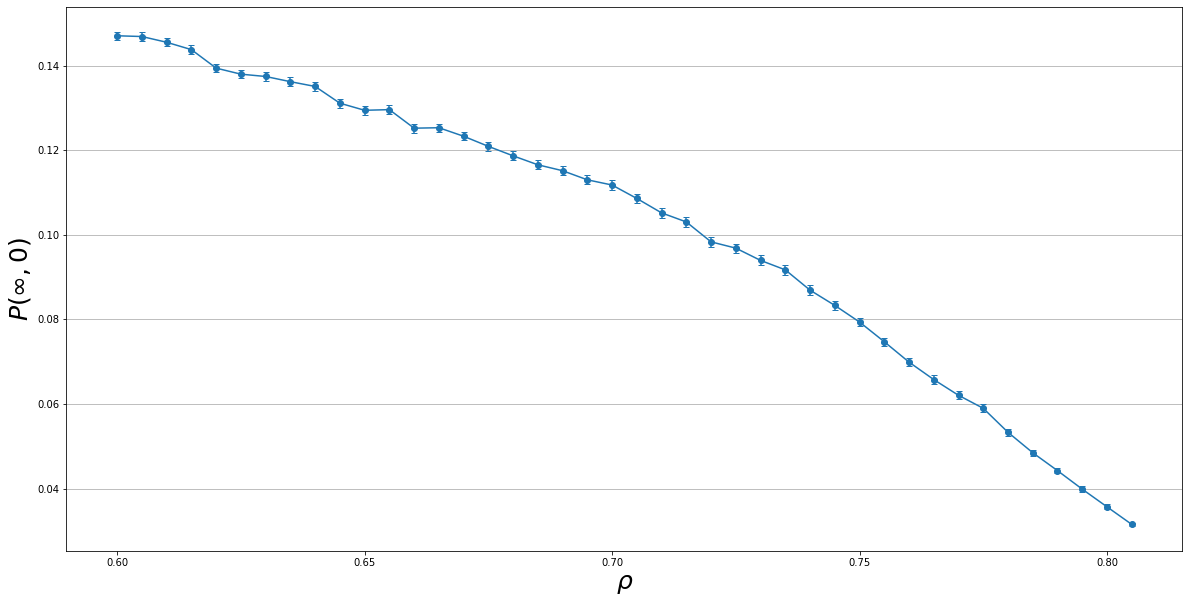

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.errorbar(points_close*0.01, aver_pers_close, yerr=errs_pers, fmt='o-', capsize=3)
plt.grid(b=True, which='major', axis='y')
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)

Text(0, 0.5, '$P(\\infty,0)$')

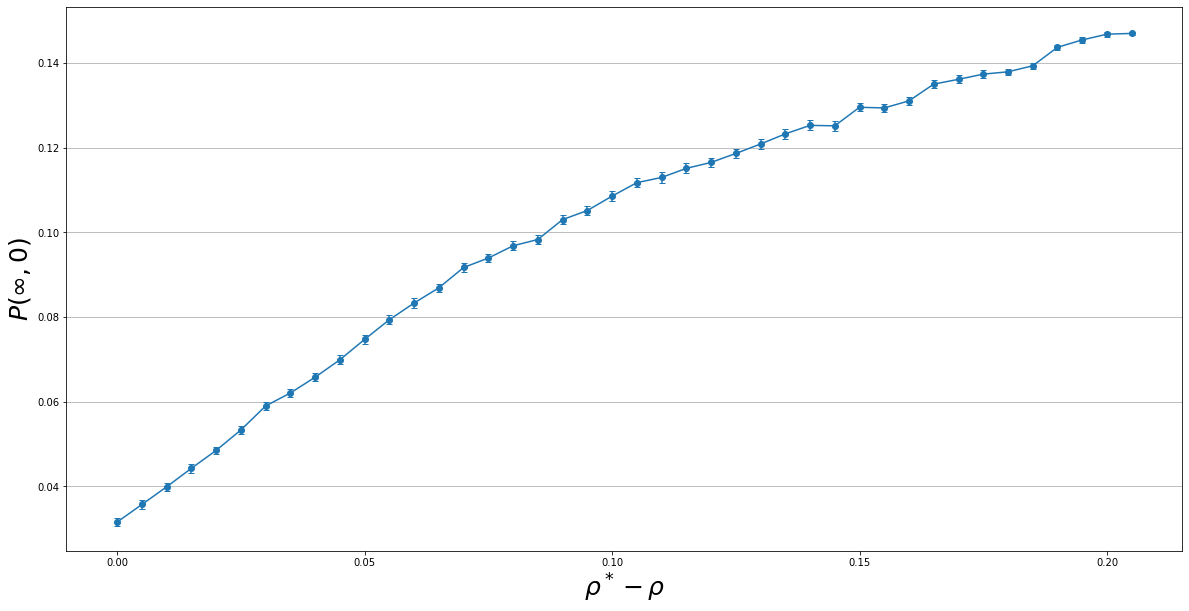

In [30]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.errorbar((p_star - points_close)[::-1]*0.01, aver_pers_close[::-1], yerr=errs_pers, fmt='o-', capsize=3)
plt.grid(b=True, which='major', axis='y')
ax.set_xlabel('$%s$'%'\\rho^* - \\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)

$ P(\infty, 0)\propto (\rho - \rho^*)^\alpha$

$\ln{P(\infty,0)}\propto \alpha \ln{(\rho - \rho^*)}$

In [55]:
pp = (p_star - points_close)[::-1][1:]*0.01 #исключая ноль
lnpp = np.log(pp)

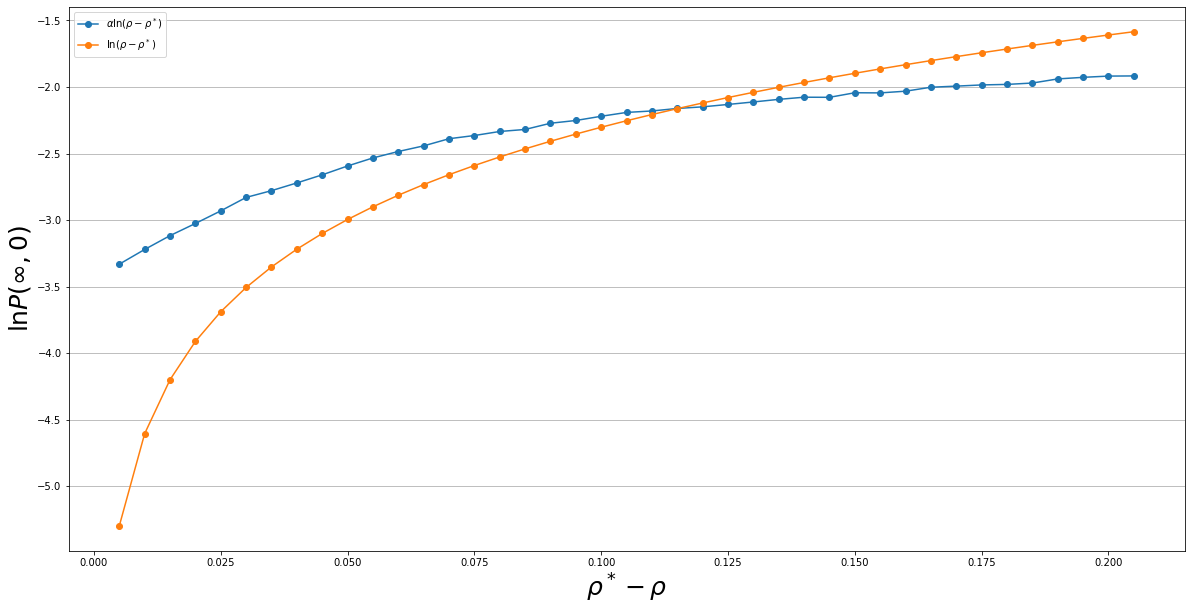

In [56]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(pp, np.log(aver_pers_close[::-1][1:]), '-o', label='$%s$'%'\\alpha \ln{(\\rho - \\rho^*)}')
ax.plot(pp, lnpp, '-o', label='$%s$'%'\ln{(\\rho - \\rho^*)}')
plt.grid(b=True, which='major', axis='y')
ax.set_xlabel('$%s$'%'\\rho^* - \\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\ln{P(\\infty,0)}',fontsize=25)
ax.legend()

$\alpha = \frac{\alpha \ln{(\rho - \rho^*)}}{\ln{(\rho - \rho^*)}} = \langle\frac{\ln{P(\infty,0)}}{\ln{(\rho - \rho^*)}}\rangle$

In [66]:
alpha = np.mean(np.log(aver_pers_close[::-1][1:]) / lnpp)
print(alpha)

0.9749998084497835
